In [1]:
# Import all required libraries

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Base location of all data
dataDirectory = 'D:\\LANL\\2015\\'

# timestsamp to enable runtime measurement
start = datetime.now()

# Set the timeSlice to 10 minutes for feature generation
timeSlice = 600 

# Variables for calculating the number of seconds in an hour and day
secHour = 3600
secDay = 86400

def nans(df): return df[df.isnull().any(axis=1)]

In [2]:
redCols = ['Time', 'User', 'SourceComputer', 'DestComputer']
redDf = pd.read_csv(dataDirectory + 'Raw\\redteam.txt.gz', names=redCols)
redDf['Day'] = redDf['Time'].apply(lambda x : int((x/secDay)+1))
redDf['Hour'] = redDf['Time'].apply(lambda x : int((x/secHour)%24))
redDf['Slice'] = redDf['Time'].apply(lambda x : int(x/timeSlice))
redDf = redDf.astype({'Day': 'int', 'Hour': 'int', 'Slice': 'int'})
redDf['Attack']=True
redDf

,Time,User,SourceComputer,DestComputer,Day,Hour,Slice,Attack
0,150885,U620@DOM1,C17693,C1003,2,17,251,True
1,151036,U748@DOM1,C17693,C305,2,17,251,True
2,151648,U748@DOM1,C17693,C728,2,18,252,True
3,151993,U6115@DOM1,C17693,C1173,2,18,253,True
4,153792,U636@DOM1,C17693,C294,2,18,256,True
...,...,...,...,...,...,...,...,...
744,2552687,U655@DOM1,C17693,C828,30,13,4254,True
745,2552687,U655@DOM1,C17693,C828,30,13,4254,True
746,2552687,U655@DOM1,C17693,C828,30,13,4254,True
747,2552687,U655@DOM1,C17693,C828,30,13,4254,True


In [3]:
sampleRate = 0.001
modelDf=pd.DataFrame()


for day in range(2, 16):
    procDf = pd.read_pickle('E:\\NewVersion\\Day_' +  str(day).zfill(2) + '_procFeat.pkl', compression = 'gzip')
    procDf = procDf.rename(columns={'Computers': 'ComputersProc'})
    authDf = pd.read_pickle('E:\\NewVersion\\Day_' +  str(day).zfill(2) + '_authFeat.pkl', compression = 'gzip')
    authDf = authDf.rename(columns={'SourceUser': 'User'})
    
    # Filter User data only and Merge process and authentication features into a single dataframe
    procDf = procDf[procDf['User'].str.contains('^U[0-9]{1}')]
    authDf = authDf[authDf['User'].str.contains('^U[0-9]{1}')]

    mergeDf = procDf.merge(authDf, how='outer', left_on=['Day', 'Hour', 'Slice', 'User'], \
                               right_on=['Day', 'Hour', 'Slice', 'User'])

    # Add the attack truth data, adding a new 'Attack' column set it to True or False
    mergeDf = mergeDf.merge(redDf[redDf['Day']==day], how='left', left_on=['Day', 'Hour', 'Slice', 'User'], \
                               right_on=['Day', 'Hour', 'Slice', 'User'])

    # Get rid of any null values 
    
    mergeDf['Attack'].fillna(False, inplace=True)
    mergeDf=mergeDf.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna(''))
#    mergeDf['Human'] = mergeDf['User'].str.contains('^U')
    mergeDf = mergeDf[mergeDf['Attack']].append(mergeDf.sample(frac=sampleRate))
    
    modelDf = modelDf.append(mergeDf[['ProcCntNorm', \
           'UniqueProcCntNorm', 'UniqueCompCntNorm', \
            'SuccessfulLogonCnt', 'FailedLogonCnt',  \
            'AuthKerberos', 'AuthNTLM', 'AuthMicrosoft', 'AuthNegotiate', 'AuthUnknown', \
            'LogonNet', 'LogonService', 'LogonClearText', 'LogonBatch', 'LogonInteractive', 'LogonUnlock', \
            'LogonCreds', 'LogonUnknown', 'OrientLogon', 'OrientLogoff', 'OrientTGS', 'OrientTGT', 'OrientAuthMap', \
            'Machine', 'UniqueDestUserNorm', 'UniqueSourceCompNorm', 'UniqueDestCompNorm', 'Attack']].\
             sample(frac=1, random_state=42))
print('Number of sessions = ' +str(len(modelDf)))

Number of sessions = 6130


In [7]:
for column in range(5,24):
    modelDf.iloc[:,column].fillna(False, inplace=True) 
    modelDf.iloc[:,column] = pd.to_numeric(modelDf.iloc[:, column])

modelDf['Attack'] = pd.to_numeric(modelDf['Attack'])
#modelDf['Human'] = pd.to_numeric(modelDf['Human'])
modelDf['Attack'].fillna(False, inplace=True)
#modelDf['Human'].fillna(False, inplace=True)
modelDf[modelDf['Attack']]

,ProcCntNorm,UniqueProcCntNorm,UniqueCompCntNorm,SuccessfulLogonCnt,FailedLogonCnt,AuthKerberos,AuthNTLM,AuthMicrosoft,AuthNegotiate,AuthUnknown,...,OrientLogon,OrientLogoff,OrientTGS,OrientTGT,OrientAuthMap,Machine,UniqueDestUserNorm,UniqueSourceCompNorm,UniqueDestCompNorm,Attack
18940,0.715232,0.622030,0.761905,56.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.770370,2.777448,2.240000,True
383358,0.000000,0.000000,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.808824,0.564103,0.294118,True
18858,0.715232,0.622030,0.761905,17.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.770370,1.080119,0.640000,True
281445,0.000000,0.000000,0.000000,23.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.000000,2.442953,2.280702,True
110423,0.464646,0.807018,1.000000,26.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.769231,2.000000,2.054795,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281439,0.000000,0.000000,0.000000,5.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.046980,0.912281,True
54841,0.740260,1.280899,1.000000,3.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.948148,1.396364,0.677249,True
89144,7.409326,4.333333,0.962963,25.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.339286,3.157895,2.530675,True
329518,0.000000,0.000000,0.000000,14.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.888889,1.218274,1.330561,True


In [13]:
modelDf=modelDf.sample(frac=1)

In [14]:
# Now the machine learning bit!
from sklearn import svm
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Create the training and test datasets from model data
modelDf = modelDf.drop_duplicates()
modelDf.Attack = modelDf.Attack.astype('bool')
xlabs = modelDf.columns.values.tolist()
xlabs.remove('Attack')
x = modelDf[xlabs].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(x, modelDf.Attack, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train_scaled,y_train)

predicted = clf.predict(X_train_scaled)
fScore = clf.decision_function(X_train_scaled)

print('F-Core for training data: ' + str(fScore))
print('Predicted attack positions: ')
print(np.where(predicted))

print('True attack positions: ')
print(np.where(y_train))

print('Intersection: ')
print(np.intersect1d(np.where(y_train), np.where(predicted)))

F-Core for training data: [-6.37391431 -7.25487763 -7.14690182 ... -6.83029823 -6.66496751
  5.55405272]
Predicted attack positions: 
(array([  21,   23,   26,   32,   35,   48,   56,   57,   59,   60,   74,
         75,   83,   91,   95,  114,  128,  133,  136,  137,  140,  145,
        149,  159,  163,  170,  173,  177,  180,  197,  201,  205,  211,
        215,  217,  244,  270,  271,  274,  306,  312,  314,  316,  370,
        383,  404,  408,  429,  444,  451,  464,  474,  481,  482,  501,
        509,  524,  550,  571,  573,  581,  593,  614,  616,  617,  625,
        626,  628,  631,  636,  653,  665,  680,  690,  691,  693,  697,
        709,  721,  728,  742,  745,  749,  758,  762,  777,  794,  805,
        823,  830,  831,  837,  849,  852,  859,  862,  864,  871,  895,
        900,  929,  933,  975,  981,  989, 1001, 1008, 1009, 1013, 1015,
       1034, 1043, 1047, 1053, 1058, 1064, 1070, 1079, 1086, 1093, 1100,
       1111, 1113, 1125, 1154, 1157, 1174, 1175, 1184, 1191, 1

C:\Users\cjasm\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\Users\cjasm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
X_test_scaled = scaler.transform(X_test)

predicted=clf.predict(X_test_scaled)
fScore=clf.decision_function(X_test_scaled)


# Show classification results
print(classification_report(y_test,predicted))
print(accuracy_score(y_test, predicted))

print('Predicted attack positions: ')
print(np.where(predicted))

print('True attack positions: ')
print(np.where(y_test))

print('Intersection: ')
print(np.intersect1d(np.where(y_test), np.where(predicted)))

              precision    recall  f1-score   support

       False       1.00      0.95      0.98      1325
        True       0.57      1.00      0.73        82

    accuracy                           0.96      1407
   macro avg       0.78      0.98      0.85      1407
weighted avg       0.97      0.96      0.96      1407

0.9559346126510305
Predicted attack positions: 
(array([  11,   16,   20,   34,   51,   63,   90,   99,  106,  111,  131,
        148,  155,  162,  167,  178,  193,  207,  235,  245,  253,  272,
        279,  283,  295,  326,  332,  342,  355,  369,  382,  386,  387,
        388,  402,  403,  406,  418,  423,  432,  440,  455,  481,  496,
        499,  520,  541,  561,  572,  579,  582,  590,  608,  619,  631,
        633,  637,  638,  639,  647,  657,  669,  675,  677,  703,  717,
        726,  731,  736,  737,  749,  756,  758,  768,  771,  800,  802,
        803,  805,  808,  834,  835,  837,  856,  878,  880,  881,  882,
        887,  912,  932,  935,  946,  97

In [16]:
cnt=0
for x in predicted:
    if x:
        cnt+=1
print('Predicted Attacks ' + str(cnt))
      
cnt=0
for x in y_test:
    if x:
        cnt+=1
print('True Attacks ' + str(cnt))
      
cnt=0
for x in np.intersect1d(np.where(y_test), np.where(predicted)):
    if x:
        cnt+=1
print('overlap ' + str(cnt))

Predicted Attacks 144
True Attacks 82
overlap 82


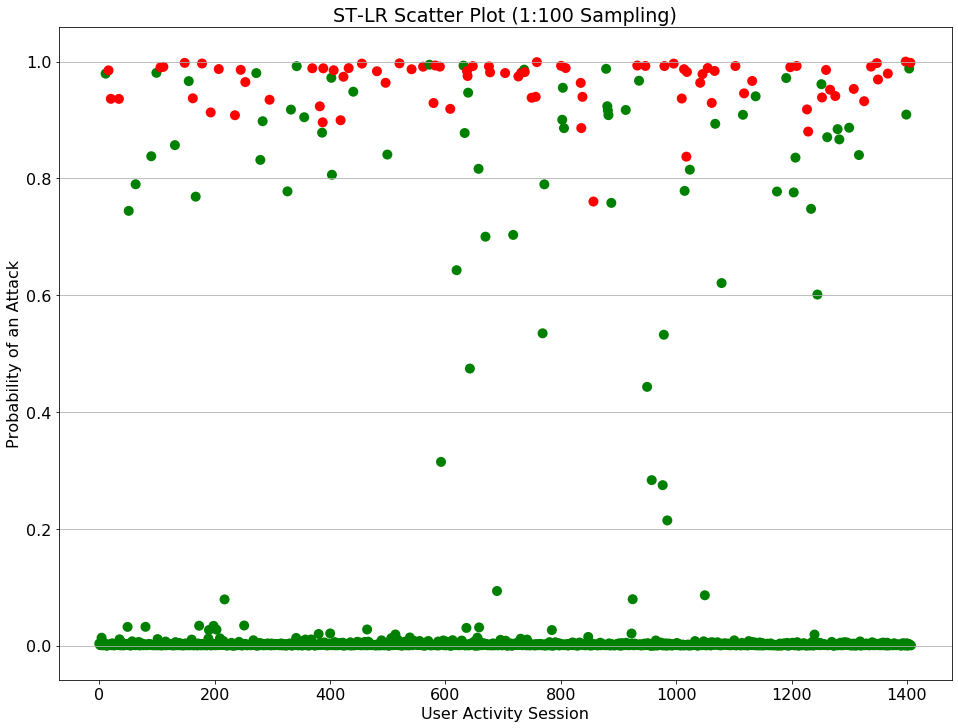

In [17]:
predicted = clf.predict_proba(X_test_scaled)[:,1]
x = np.linspace(0, len(predicted), len(predicted))
y = predicted

plt.rc('font', size=16)  
plt.figure(figsize=(16,12))
plt.xlabel('User Activity Session')
plt.ylabel('Probability of an Attack')
plt.title('ST-LR Scatter Plot (1:100 Sampling)')

colour = np.where(y_test==0,'g',np.where(y_test==1,'r','b'))
plt.scatter(x, y, c=colour, s=100, linewidth=0)
plt.grid(axis='y', linestyle='-')
plt.show()

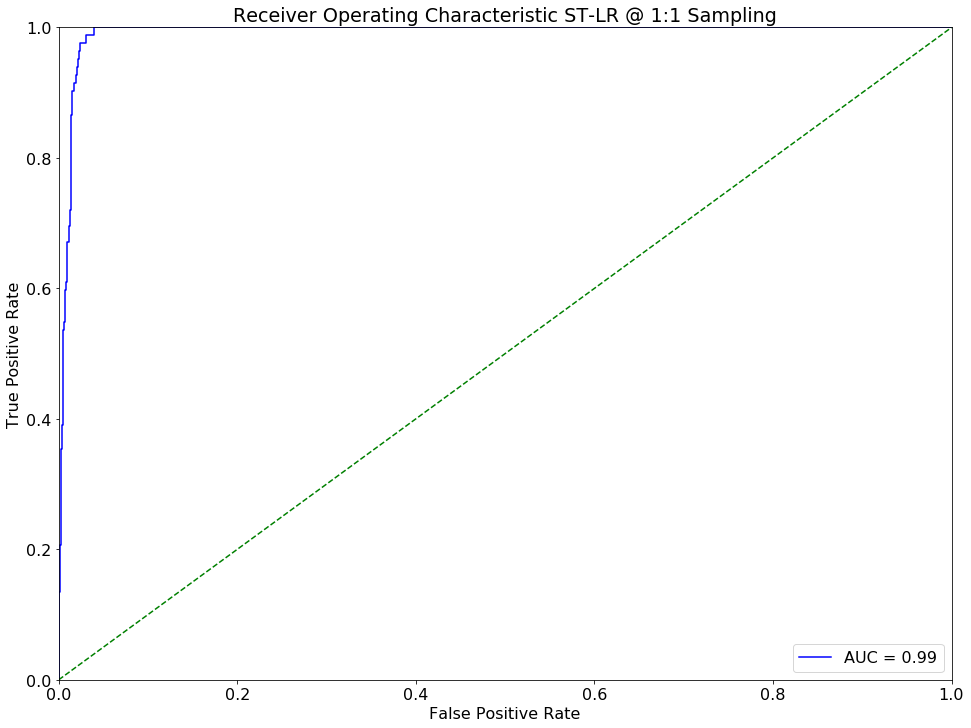

In [18]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(16,12))
plt.title('Receiver Operating Characteristic ST-LR @ 1:1 Sampling')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

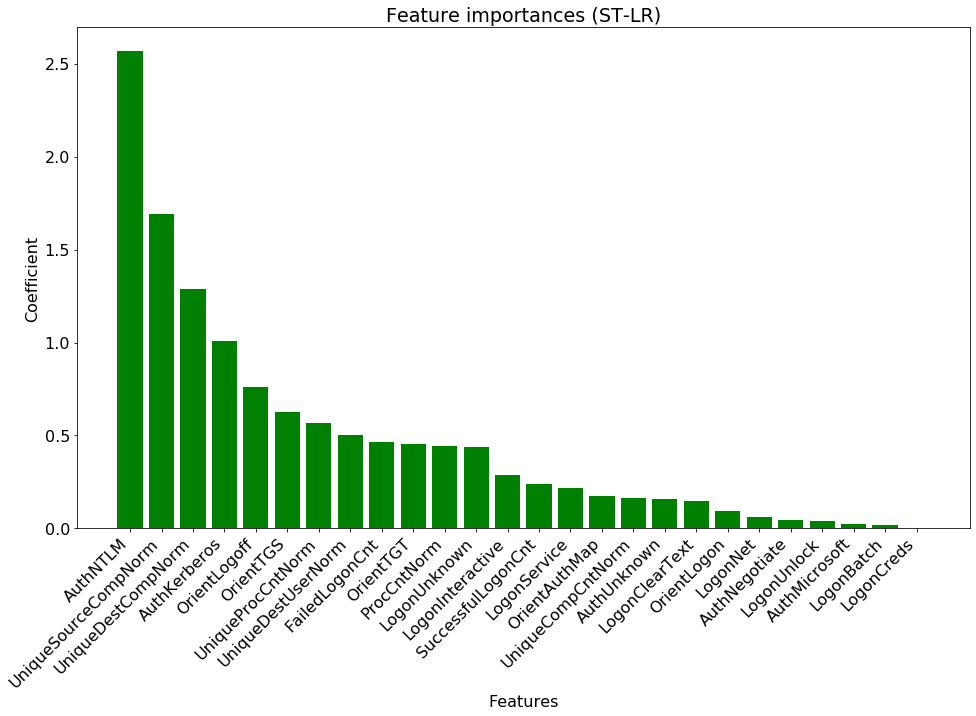

In [19]:
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

orderedFeatures = []
features = xlabs
for index in indices:
    orderedFeatures.append(features[index])

plt.figure(figsize=(16,12))

plt.title("Feature importances (ST-LR)")
plt.ylabel('Coefficient')
plt.xlabel('Features')
plt.bar(range(26), coefs[indices[:26]], color="g", align="center")
plt.xticks(range(26), orderedFeatures, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)


In [20]:
# Remove the top 2 features and see how the model performs

# Create the training and test datasets from model data

xlabs = modelDf.columns.values.tolist()
xlabs.remove('AuthNTLM')
xlabs.remove('Machine')
xlabs.remove('Attack')
x = modelDf[xlabs].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(x, modelDf.Attack, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train_scaled,y_train)

predicted = clf.predict(X_train_scaled)
fScore = clf.decision_function(X_train_scaled)

print('F-Core for training data: ' + str(fScore))
print('Predicted attack positions: ')
print(np.where(predicted))

print('True attack positions: ')
print(np.where(y_train))

print('Intersection: ')
print(np.intersect1d(np.where(y_train), np.where(predicted)))
X_test_scaled = scaler.transform(X_test)

predicted=clf.predict(X_test_scaled)
fScore=clf.decision_function(X_test_scaled)
print(fScore)

print('Predicted attack positions: ')
print(np.where(predicted))

print('True attack positions: ')
print(np.where(y_test))

print('Intersection: ')
print(np.intersect1d(np.where(y_test), np.where(predicted)))

F-Core for training data: [-11.13588639 -11.3591092  -11.72389005 ...  -1.20210438  -1.75878179
   5.48489064]
Predicted attack positions: 
(array([   9,   21,   25,   26,   32,   35,   53,   56,   57,   59,   60,
         71,   74,   75,   76,   87,   89,   91,   95,  114,  128,  137,
        140,  145,  157,  159,  180,  197,  201,  205,  207,  211,  221,
        225,  228,  260,  270,  273,  304,  306,  308,  312,  314,  315,
        325,  330,  340,  342,  370,  373,  391,  405,  408,  418,  429,
        434,  438,  439,  444,  451,  457,  458,  463,  464,  474,  479,
        481,  484,  490,  501,  509,  524,  540,  541,  547,  548,  562,
        584,  585,  593,  596,  613,  614,  616,  619,  622,  625,  626,
        631,  639,  642,  665,  685,  691,  697,  709,  713,  721,  728,
        742,  744,  746,  747,  749,  762,  777,  780,  792,  794,  808,
        823,  830,  837,  844,  846,  849,  852,  859,  862,  864,  872,
        887,  892,  895,  900,  929,  933,  938,  953,  

C:\Users\cjasm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\cjasm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


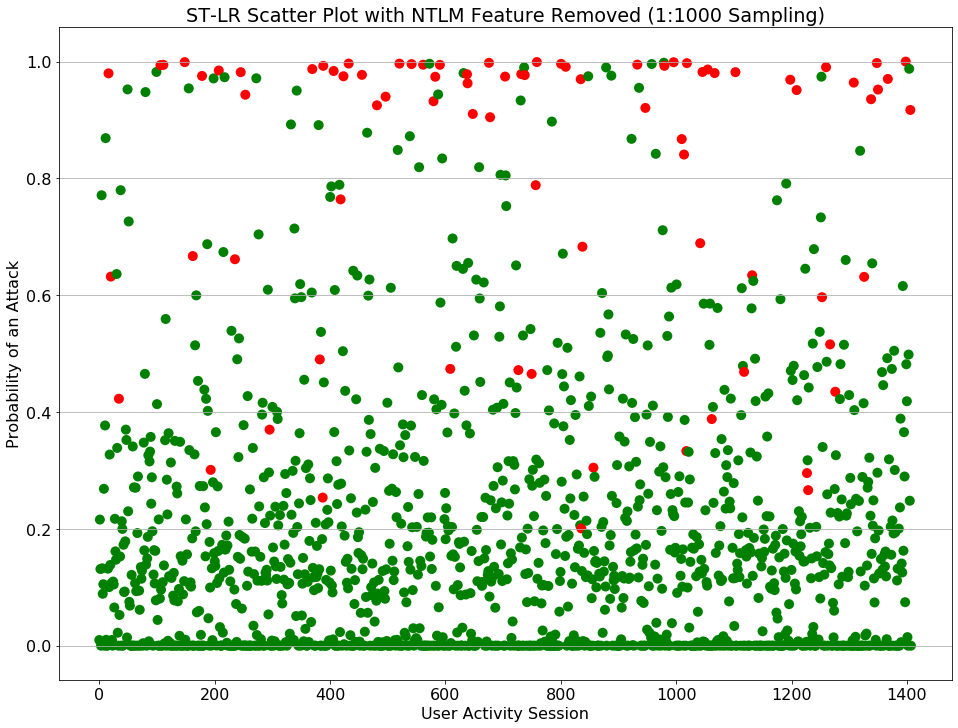

In [21]:
predicted = clf.predict_proba(X_test_scaled)[:,1]
x = np.linspace(0, len(predicted), len(predicted))
y = predicted

plt.rc('font', size=16)  
plt.figure(figsize=(16,12))
plt.xlabel('User Activity Session')
plt.ylabel('Probability of an Attack')
plt.title('ST-LR Scatter Plot with NTLM Feature Removed (1:1000 Sampling)')

colour = np.where(y_test==0,'g',np.where(y_test==1,'r','b'))
plt.scatter(x, y, c=colour, s=100, linewidth=0)
plt.grid(axis='y', linestyle='-')
plt.show()

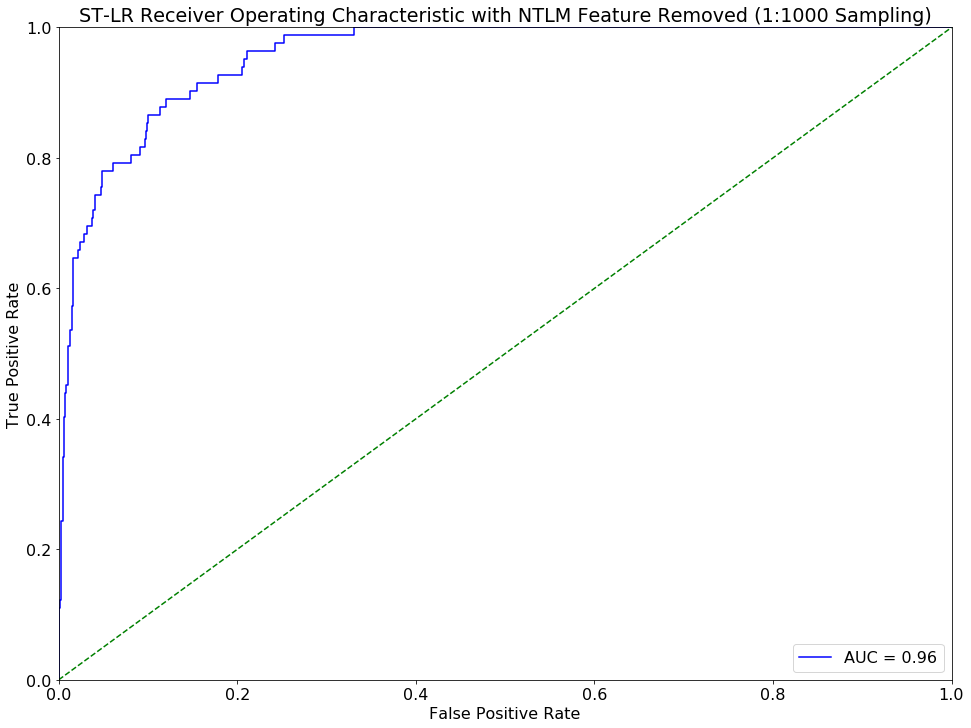

In [22]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(16,12))
plt.title('ST-LR Receiver Operating Characteristic with NTLM Feature Removed (1:1000 Sampling)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

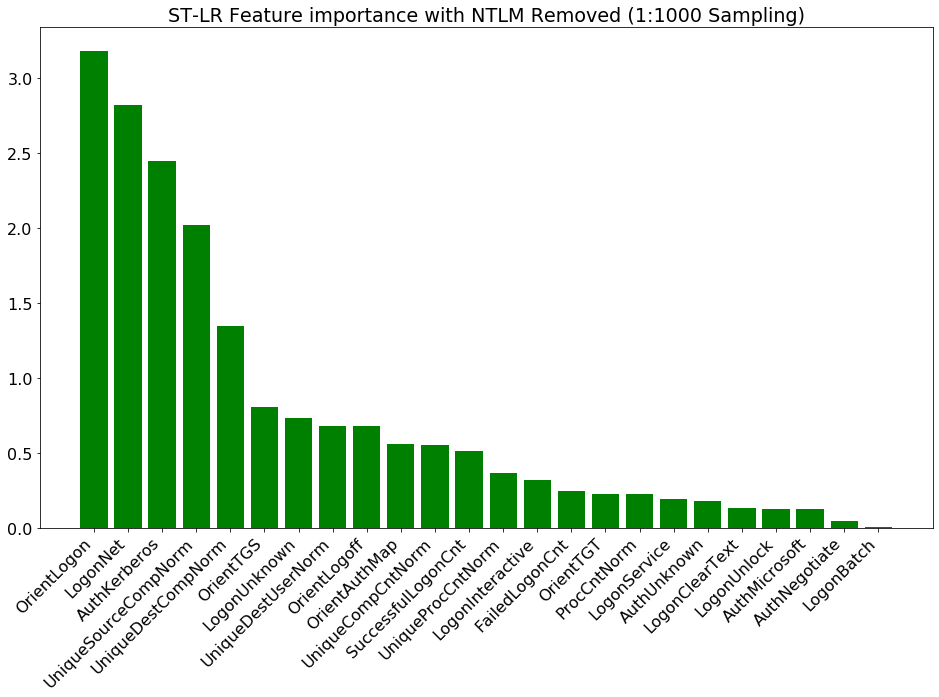

In [23]:
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

orderedFeatures = []
features = xlabs
for index in indices:
    orderedFeatures.append(features[index])

plt.figure(figsize=(16,12))
plt.title("ST-LR Feature importance with NTLM Removed (1:1000 Sampling)")
plt.bar(range(24), coefs[indices[:24]], color="g", align="center")
plt.xticks(range(24), orderedFeatures, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)


In [127]:
a= X_test[:, 0].tolist()
a

[0.0,
 0.0,
 0.0,
 0.0,
 0.8999999999999999,
 0.27358490566037735,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0451996040910592,
 0.0,
 0.0,
 0.0,
 5.616,
 0.0,
 0.0,
 0.0,
 0.0,
 5.592417061611374,
 1.5053763440860215,
 0.0,
 1.7269372693726937,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.6,
 1.4347826086956523,
 0.0,
 0.0,
 0.7449664429530201,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.3362445414847162,
 0.0,
 0.6599999999999999,
 0.8135593220338982,
 0.9154929577464789,
 0.0,
 0.0,
 0.9107806691449815,
 0.8218029350104822,
 0.979591836734694,
 0.0,
 0.0,
 0.0,
 0.5142857142857143,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9680672268907563,
 0.9536423841059603,
 0.7458379578246394,
 0.9230769230769231,
 0.8861538461538461,
 0.979591836734694,
 0.0,
 0.7627118644067797,
 0.7787444157065601,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.027546628407460545,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6216216216216216,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

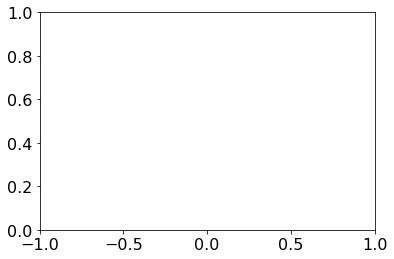

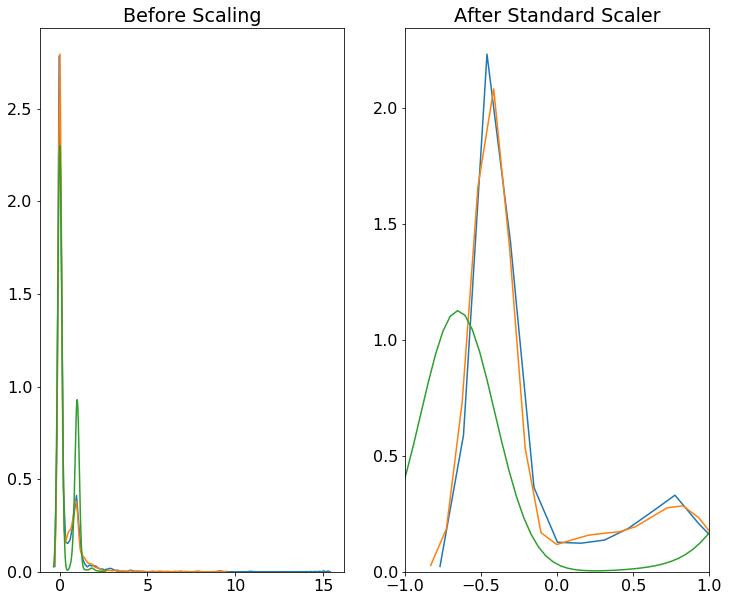

In [154]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1,1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 10))
plt.xlim(-1,1)
ax1.set_title('Before Scaling')
sns.kdeplot(X_test[:,0].tolist(), ax=ax1)
sns.kdeplot(X_test[:,1].tolist(), ax=ax1)
sns.kdeplot(X_test[:,2].tolist(), ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(X_test_scaled[:,0].tolist(), ax=ax2)
sns.kdeplot(X_test_scaled[:,1].tolist(), ax=ax2)
sns.kdeplot(X_test_scaled[:,2].tolist(), ax=ax2)

plt.show()

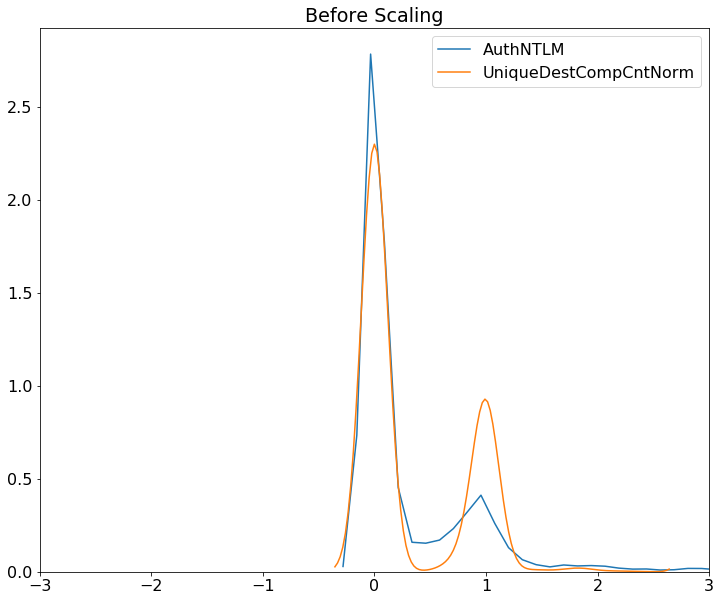

In [167]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(12, 10))
plt.xlim(-3,3)
ax1.set_title('Before Scaling')
sns.kdeplot(X_test[:,0].tolist(), ax=ax1, label='AuthNTLM')
#sns.kdeplot(X_test[:,1].tolist(), ax=ax1, label='UniqueSourceCompCntNorm')
sns.kdeplot(X_test[:,2].tolist(), ax=ax1, label='UniqueDestCompCntNorm')



plt.show()

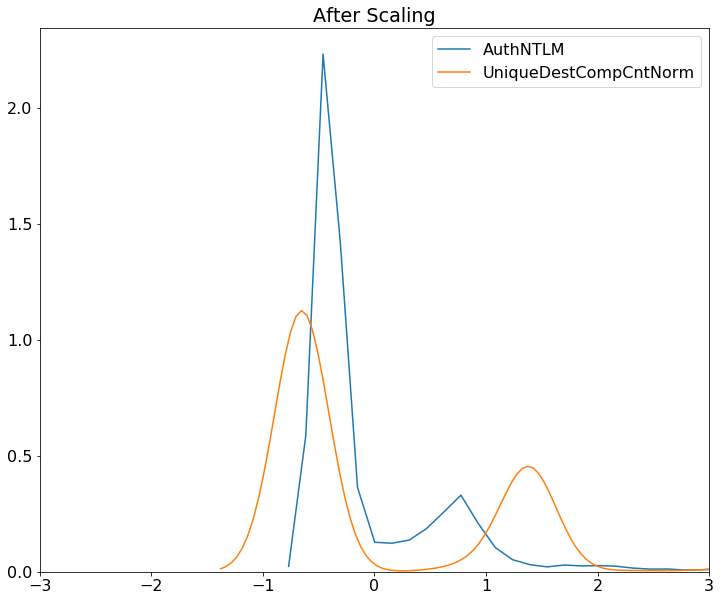

In [169]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(12, 10))
plt.xlim(-3,3)
ax1.set_title('After Scaling')
sns.kdeplot(X_test_scaled[:,0].tolist(), ax=ax1, label='AuthNTLM')
#sns.kdeplot(X_test_scaled[:,1].tolist(), ax=ax1, label='UniqueDestCompCntNorm')
sns.kdeplot(X_test_scaled[:,2].tolist(), ax=ax1, label='UniqueDestCompCntNorm')



plt.show()

In [72]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.DataFrame(columns=['x1', 'x2', 'x3'])

df['x1'] = X_test[0:]
df['x2'] = X_test[1:]
df['x3'] = X_test[2:]
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['x1'], ax=ax1)
sns.kdeplot(df['x2'], ax=ax1)
sns.kdeplot(df['x3'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['x1'], ax=ax2)
sns.kdeplot(scaled_df['x2'], ax=ax2)
sns.kdeplot(scaled_df['x3'], ax=ax2)
plt.show()

Exception: Data must be 1-dimensional